# Urban Heat Island (UHI) Benchmark Notebook
## University of Maryland - Information Challenge 2025 (IC25)

## Challenge Overview

<p align="justify">Welcome to the 2025 University of Maryland - Information Challenge 2025! The objective of this challenge is to build a machine learning model to predict urban heat island (UHI) hotspots in a specified region. By the end of the challenge, you will have developed a regression model capable of predicting the intensity of the UHI effect. Participants will be given ground-level air temperature data in an index format which was collected on 7-Aug-2022 in Montgomery County, Maryland. This dataset constitutes traverse points (latitude and longitude) and their corresponding UHI (Urban Heat Island) index values. Participants will use this dataset to build a regression model to predict UHI index values for a given set of locations. It is important to understand that the UHI Index at any given location is indicative of the relative temperature elevation at that specific point compared to the region's average temperature.
</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been constructed to predict the Urban Heat Island (UHI) index using features from the Sentinel-2 satellite dataset as predictor variables. In this demonstration, we utilized three features from the Sentinel-2 dataset: band B02 (Blue), band B03 (Green), and NDVI (Normalized Difference Vegetation Index) derived from bands B04 (Red) and B08 (Near Infrared). A random forest regression model was then trained using these features.
    
These features were extracted from a GeoTIFF image created by the Sentinel-2 sample notebook. For the sample model shown in this notebook, data from a single day (13th August 2022) was considered, assuming that the values of bands B02, B03, B04, and B08 for this specific date are representative of the UHI index behavior at any location. Participants should review the details of the Sentinel-2 sample notebook to gain an understanding of the data and options for modifying the output product. 
    
</p>

<p align="justify">Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2-Level-2A notebook</a> found in the Planetary Computer portal.</p>

<p align="justify">Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>


In [58]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

In [59]:
# Combining ground data and final data into a single dataset.
uhi = pd.read_csv("output2000.csv")
train_data = pd.read_csv("Training_Data_IC25.csv")  # Second dataset

# Combine them side by side
uhi_data = pd.concat([train_data, uhi], axis=1)
uhi_data.columns =  ['Longitude', 'Latitude', 'UHI Index', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
uhi_data.head()

,Longitude,Latitude,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,-77.302700,39.109905,0.993571,1248.8251,1334.9159,1554.5948,1360.3296,1896.3672,3738.9858,4453.1330,4757.1270,4758.9700,3003.8647,1982.7068
1,-77.302690,39.109855,0.994674,1248.9591,1335.0741,1554.8250,1360.6029,1896.7305,3739.1758,4453.2075,4757.2983,4759.0930,3004.5437,1983.2352
2,-77.302677,39.109960,0.993571,1248.7036,1334.7628,1554.3951,1360.0830,1896.0524,3738.8250,4453.0520,4757.0454,4758.8710,3003.2703,1982.2407
3,-77.302655,39.109808,0.994674,1249.0876,1335.2197,1555.0603,1360.8525,1897.0952,3739.3970,4453.3450,4757.5513,4759.2740,3005.1963,1983.7444
4,-77.302630,39.110017,0.993571,1248.6064,1334.6377,1554.2472,1359.8597,1895.8171,3738.7290,4453.0370,4757.1445,4758.8145,3002.7650,1981.8457


In [60]:
# Transform features add it to the dataset
uhi_data['NDVI'] = (uhi_data['B08'] - uhi_data['B04']) / (uhi_data['B08'] +  uhi_data['B04'])
uhi_data['NDVI'] = uhi_data['NDVI'].replace([np.inf, -np.inf], np.nan) 

uhi_data['NDBI'] = (uhi_data['B11'] - uhi_data['B08']) / (uhi_data['B11'] + uhi_data['B08'])
uhi_data['NDBI'] = uhi_data['NDBI'].replace([np.inf, -np.inf], np.nan)

## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01','B04','B06','B08','NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [61]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['B01', 'B02','B03','B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'NDVI', 'NDBI']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first') 

uhi_data["Moisture Content"] = uhi_data["B11"] / uhi_data["B12"] 
uhi_data["Soil Ratio"] = uhi_data["B06"] / uhi_data["B07"] 
uhi_data["Vegetation Health"] = uhi_data["B08"] / uhi_data["B02"]

uhi_data.head()


,Longitude,Latitude,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,NDBI,Moisture Content,Soil Ratio,Vegetation Health
0,-77.302700,39.109905,0.993571,1248.8251,1334.9159,1554.5948,1360.3296,1896.3672,3738.9858,4453.1330,4757.1270,4758.9700,3003.8647,1982.7068,0.555263,-0.225907,1.515032,0.839630,3.563616
1,-77.302690,39.109855,0.994674,1248.9591,1335.0741,1554.8250,1360.6029,1896.7305,3739.1758,4453.2075,4757.2983,4759.0930,3004.5437,1983.2352,0.555206,-0.225817,1.514971,0.839659,3.563322
2,-77.302677,39.109960,0.993571,1248.7036,1334.7628,1554.3951,1360.0830,1896.0524,3738.8250,4453.0520,4757.0454,4758.8710,3003.2703,1982.2407,0.555320,-0.225993,1.515089,0.839610,3.563963
3,-77.302655,39.109808,0.994674,1249.0876,1335.2197,1555.0603,1360.8525,1897.0952,3739.3970,4453.3450,4757.5513,4759.2740,3005.1963,1983.7444,0.555161,-0.225739,1.514911,0.839683,3.563122
4,-77.302630,39.110017,0.993571,1248.6064,1334.6377,1554.2472,1359.8597,1895.8171,3738.7290,4453.0370,4757.1445,4758.8145,3002.7650,1981.8457,0.555384,-0.226082,1.515136,0.839591,3.564371


In [62]:
# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)

## Correlation Coeficient between UHI Index	and other features

B12                  0.381092
NDBI                 0.376457
B04                  0.346036
B02                  0.345196
B03                  0.344160
B01                  0.340881
B05                  0.338865
Soil Ratio           0.338383
B11                  0.251680
B06                 -0.190020
B07                 -0.263466
B8A                 -0.273501
B08                 -0.282041
Moisture Content    -0.340878
Vegetation Health   -0.342074
NDVI                -0.342224
dtype: float64


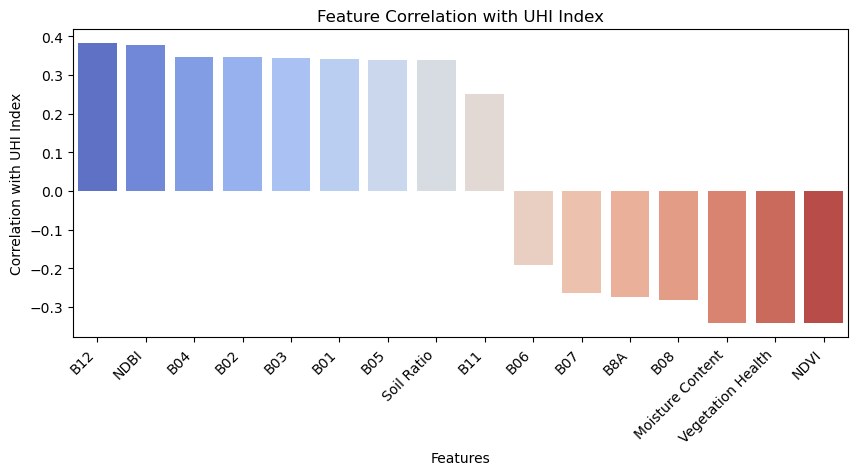

Selected Features: Index(['B12', 'NDBI', 'B04', 'B02', 'B03', 'B01', 'B05', 'Soil Ratio',
       'Moisture Content', 'Vegetation Health', 'NDVI'],
      dtype='object')


In [63]:
UHI_Feature = uhi_data.drop(columns=['Longitude', 'Latitude', 'UHI Index'])
UHI_Target = uhi_data['UHI Index']
correlation_with_UHI = UHI_Feature.corrwith(UHI_Target)


# Sort correlation values
correlation_with_UHI = correlation_with_UHI.sort_values(ascending=False)
print(correlation_with_UHI)

# Plot the correlation as a bar chart
plt.figure(figsize=(10, 4))
sns.barplot(x=correlation_with_UHI.index, y=correlation_with_UHI.values, palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Correlation with UHI Index")
plt.title("Feature Correlation with UHI Index")
plt.show()

# Set a correlation threshold (e.g., > 0.3)
selected_features = correlation_with_UHI[correlation_with_UHI.abs() > 0.3].index

# Keep only selected features
X_selected = UHI_Feature[selected_features]

print("Selected Features:", selected_features)

## Model Building

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only Band B01, Band B06 and NDVI from the Sentinel-2 data as our predictor variables. <br><br>
<b>IMPORTANT</b> ... The use of Latitude and Longitude as predictor variables is prohibited. Using such data does achieve very high scores due to spatial autocorrelation but does not allow the model to be generalized for use in other regions. Your model should ONLY use the Sentinel-2 satellite data as a means to define the environment near a given location.</p>


In [64]:
# Retaining only the columns for B02, B03, NDVI, and UHI Index in the dataset.
model_data = uhi_data[['B01', 'B02', 'B05', 'B06', 'B08', 'B8A', 'B11', 'B12', 'NDVI', 'NDBI',  
'Moisture Content', 'Soil Ratio', 'Vegetation Health', 'UHI Index']]
print(uhi_data.head())

   Longitude   Latitude  UHI Index        B01        B02        B03  \
0 -77.302700  39.109905   0.993571  1248.8251  1334.9159  1554.5948   
1 -77.302690  39.109855   0.994674  1248.9591  1335.0741  1554.8250   
2 -77.302677  39.109960   0.993571  1248.7036  1334.7628  1554.3951   
3 -77.302655  39.109808   0.994674  1249.0876  1335.2197  1555.0603   
4 -77.302630  39.110017   0.993571  1248.6064  1334.6377  1554.2472   

         B04        B05        B06        B07        B08        B8A  \
0  1360.3296  1896.3672  3738.9858  4453.1330  4757.1270  4758.9700   
1  1360.6029  1896.7305  3739.1758  4453.2075  4757.2983  4759.0930   
2  1360.0830  1896.0524  3738.8250  4453.0520  4757.0454  4758.8710   
3  1360.8525  1897.0952  3739.3970  4453.3450  4757.5513  4759.2740   
4  1359.8597  1895.8171  3738.7290  4453.0370  4757.1445  4758.8145   

         B11        B12      NDVI      NDBI  Moisture Content  Soil Ratio  \
0  3003.8647  1982.7068  0.555263 -0.225907          1.515032    0.83

### UHI Index Distribution

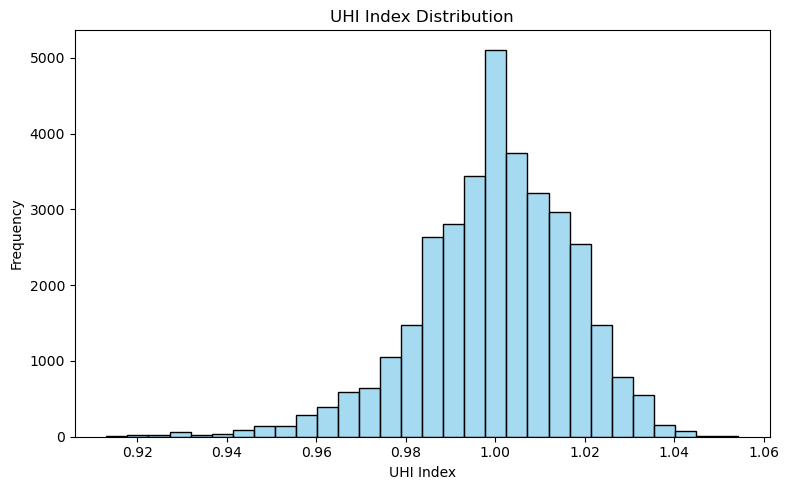

In [65]:
# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(data=model_data, x='UHI Index', bins=30, color='skyblue', kde=False)

# Customize the plot
plt.title('UHI Index Distribution')
plt.xlabel('UHI Index')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Train and Test Split 

<p align="justify">We will now split the data into 80% training data and 20% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [66]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = model_data.drop(columns=['UHI Index'])
y = model_data['UHI Index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]),
 [Text(0.5, 0, 'B01'),
  Text(1.5, 0, 'B02'),
  Text(2.5, 0, 'B05'),
  Text(3.5, 0, 'B06'),
  Text(4.5, 0, 'B08'),
  Text(5.5, 0, 'B8A'),
  Text(6.5, 0, 'B11'),
  Text(7.5, 0, 'B12'),
  Text(8.5, 0, 'NDVI'),
  Text(9.5, 0, 'NDBI'),
  Text(10.5, 0, 'Moisture Content'),
  Text(11.5, 0, 'Soil Ratio'),
  Text(12.5, 0, 'Vegetation Health')])

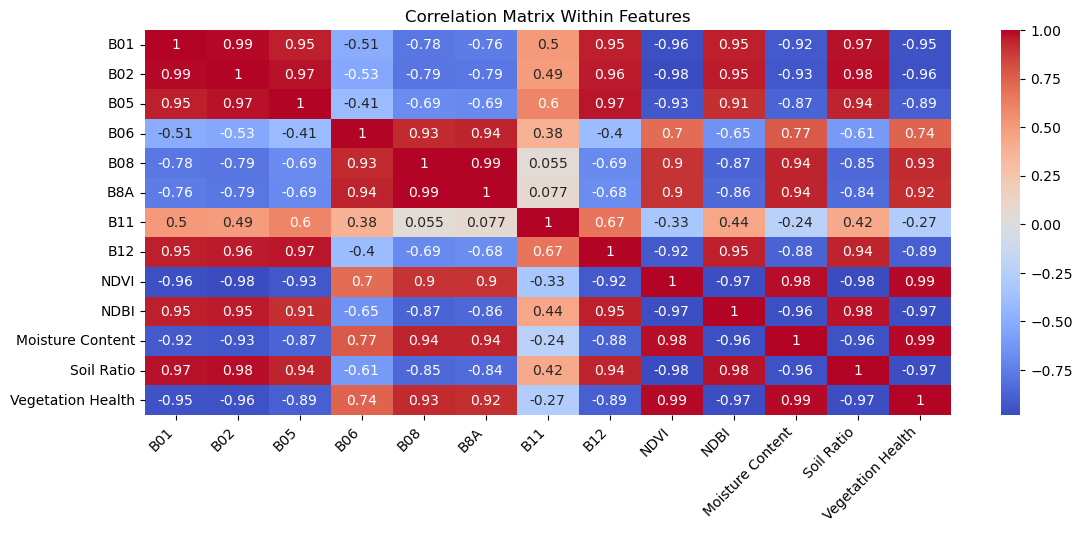

In [67]:
plt.figure(figsize=(13, 5))
corr_matrix = X_train.corr()
plt.title('Correlation Matrix Within Features')
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.xticks(rotation=45, ha='right')

### Feature Scaling 

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of B01, B06, NDVI variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler. The idea behind Standard Scaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.</p>

In [68]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

### Model Training

<p align="justify">Now that we have the data in a format suitable for machine learning, we can begin training a model. In this demonstration notebook, we will use a random forest regression model from the scikit-learn library. This library offers a wide range of other models, each with extensive parameter tuning and customization capabilities.</p>

<p align="justify">Scikit-learn models require the separation of predictor variables and the response variable. We will store the predictor variables (Band B01, B06, NDVI) in array X and the response variable (UHI index) in array Y. It is important not to include the response variable in array X. Additionally, since latitude and longitude do not contribute to the prediction of UHI in this case, we will drop those as well.</p>


## XGboost model

In [69]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,      # Number of trees (increase for better accuracy)
    learning_rate=0.005,    # Step size shrinkage
    max_depth=20,           # Tree depth
    subsample=0.8,         # Subsampling to prevent overfitting
    colsample_bytree=0.8,  # Features per tree
    reg_lambda=0.001,
    random_state=42
)


# Train the model
xgb_model.fit(X_train_scaled, y_train) 




XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

              Feature  Importance
11         Soil Ratio    0.123979
10   Moisture Content    0.108313
9                NDBI    0.101405
12  Vegetation Health    0.094256
7                 B12    0.086565
8                NDVI    0.067179
6                 B11    0.065972
0                 B01    0.063502
2                 B05    0.061525
4                 B08    0.059340
5                 B8A    0.059163
3                 B06    0.055557
1                 B02    0.053243


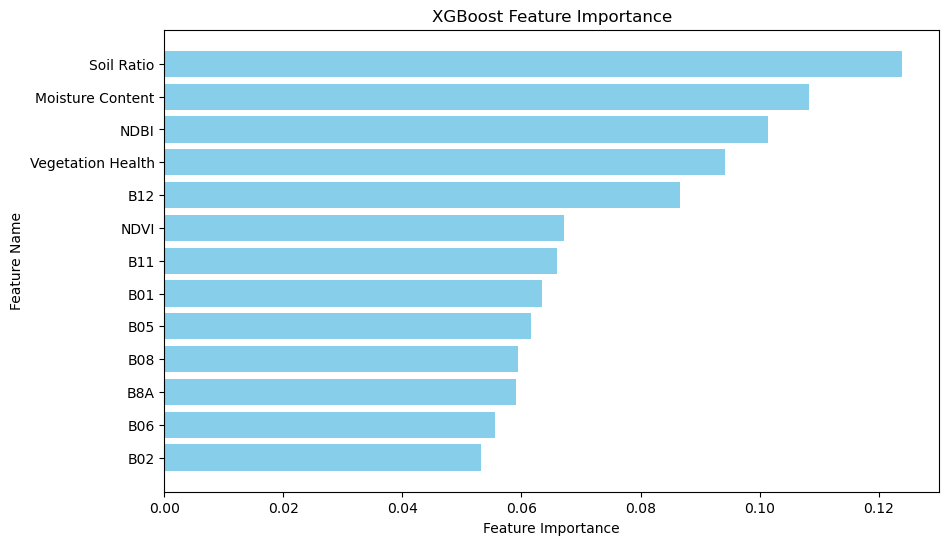

In [70]:
# Get feature importance scores
feature_importance = xgb_model.feature_importances_

# Convert to DataFrame for better readability
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort by importance (descending)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  
plt.show()

In [71]:
# Make predictions on the training data
xgb_training_predictions = xgb_model.predict(X_train_scaled)
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, xgb_training_predictions)

0.9964556097984314

In [72]:
xgb_y_pred = xgb_model.predict(X_test_scaled)
r2 = r2_score(y_test, xgb_y_pred)
print(f"R-squared (R²): {r2:.4f}")

R-squared (R²): 0.9414


### Use the whole training set to train the model

In [73]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,      # Number of trees (increase for better accuracy)
    learning_rate=0.005,    # Step size shrinkage
    max_depth=20,           # Tree depth
    subsample=0.8,         # Subsampling to prevent overfitting
    colsample_bytree=0.8,  # Features per tree
    reg_lambda=0.001,
    random_state=42
)


# Train the model
xgb_model.fit(X_scaled, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

              Feature  Importance
11         Soil Ratio    0.124554
10   Moisture Content    0.104526
9                NDBI    0.102494
12  Vegetation Health    0.085600
7                 B12    0.082982
8                NDVI    0.070806
0                 B01    0.068607
6                 B11    0.067902
2                 B05    0.063666
5                 B8A    0.057788
3                 B06    0.057671
4                 B08    0.057628
1                 B02    0.055775


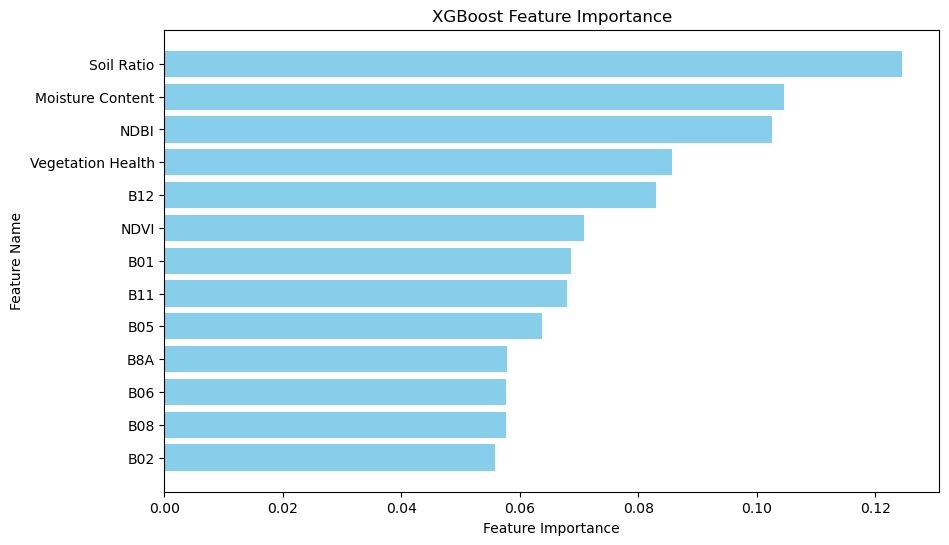

In [74]:
# Get feature importance scores
feature_importance = xgb_model.feature_importances_

# Convert to DataFrame for better readability
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort by importance (descending)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  
plt.show()

In [75]:
# Make predictions on the training data
xgb_training_predictions = xgb_model.predict(X_scaled)
# calculate R-squared score for in-sample predictions
Y_train = y.tolist()
r2_score(Y_train, xgb_training_predictions)

0.9960031509399414

## Submission

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

In [76]:
#Reading the coordinates for the submission
test_file = pd.read_csv('Submission_Template_IC25.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-77.301697,39.109247,NaN
1,-77.300382,39.113362,NaN
2,-77.300285,39.108433,NaN
3,-77.299315,39.107880,NaN
4,-77.299300,39.115225,NaN


### Transform the raw testing data to the buff area(average 2000 meters nearby for per pixel)

In [77]:
import pandas as pd
import rioxarray as rxr
import rasterio
from rasterio.mask import mask
from pyproj import Transformer, CRS
from shapely.geometry import Point, mapping
import numpy as np
import torch
from tqdm import tqdm

def extract_buffered_satellite_data(tiff_path, csv_path, buffer_distance=2000, use_gpu=True):
    device = torch.device("cuda" if torch.cuda.is_available() and use_gpu else "cpu")
    print(f"Using device: {device}")

    dataset = rxr.open_rasterio(tiff_path)
    tiff_crs = dataset.rio.crs
    print(f"Original TIFF CRS: {tiff_crs}")
    
    # Ensure the TIFF is in a projected coordinate system (not EPSG:4326)
    if not tiff_crs.is_projected:
        print("Reprojecting TIFF to UTM for correct buffering...")
        reprojected_tiff_path = "reprojected.tif"
        dataset = dataset.rio.reproject(dst_crs=CRS.from_epsg(32618))  # Example UTM Zone 18N
        dataset.rio.to_raster(reprojected_tiff_path)
        tiff_path = reprojected_tiff_path  # Use the reprojected file
        tiff_crs = dataset.rio.crs
        print(f"New TIFF CRS after reprojection: {tiff_crs}")
    
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    transformer = Transformer.from_crs("EPSG:4326", tiff_crs, always_xy=True)
    
    # Convert lat/lon to projected coordinates (meters)
    transformed_coords = np.array(transformer.transform(longitudes, latitudes))
    # print("First 5 transformed coordinates (meters):")
    # print(transformed_coords[:, :5])

    num_bands = dataset.shape[0]
    band_values = {f'B{band+1:02d}': np.full(len(df), np.nan, dtype=np.float32) for band in range(num_bands)}

    # Check raster bounds
    with rasterio.open(tiff_path) as src:
        raster_bounds = src.bounds
        print(f"Raster bounds: {raster_bounds}")
        
        for idx, (x, y) in tqdm(enumerate(zip(transformed_coords[0], transformed_coords[1])),
                                 total=len(latitudes), desc="Extracting values"):
            if not (raster_bounds.left <= x <= raster_bounds.right and raster_bounds.bottom <= y <= raster_bounds.top):
                print(f"Skipping point {idx} ({x:.2f}, {y:.2f}) - Outside raster bounds")
                continue
            
            point = Point(x, y).buffer(buffer_distance)
            geojson_geom = [mapping(point)]
            
            if idx < 5:  # Print debug info for the first few points
                print(f"Point {idx}: ({x:.2f}, {y:.2f}) -> Buffered Geometry: {geojson_geom}")
            
            try:
                out_image, _ = mask(src, geojson_geom, crop=True)
                
                # Compute the mean for each band
                for band in range(out_image.shape[0]):
                    band_values[f'B{band+1:02d}'][idx] = np.nanmean(out_image[band])
                
                if idx < 5:  # Debug output for the first few iterations
                    print(f"Extracted mean band values for point {idx}:", 
                          [np.nanmean(out_image[band]) for band in range(out_image.shape[0])])
            except Exception as e:
                print(f"Skipping point {idx} ({y:.2f}, {x:.2f}) due to error: {e}")

    band_df = pd.DataFrame(band_values)
    return band_df

# Example usage:
val_data = extract_buffered_satellite_data('S2_output_IC25(complete).tiff', 'Submission_Template_IC25.csv')

Using device: cuda
Original TIFF CRS: EPSG:4326
Reprojecting TIFF to UTM for correct buffering...
New TIFF CRS after reprojection: EPSG:32618
Raster bounds: BoundingBox(left=297192.31406539254, bottom=4311830.711916517, right=336053.61640117853, top=4347129.585479343)


Extracting values:   0%|          | 0/3834 [00:00<?, ?it/s]

Point 0: (300987.85, 4331422.22) -> Buffered Geometry: [{'type': 'Polygon', 'coordinates': (((302987.8532536066, 4331422.220179), (302978.22270695097, 4331226.185898341), (302949.4238144131, 4331032.039534967), (302901.733925071, 4330841.650824491), (302835.61231862917, 4330656.853314269), (302751.6957823033, 4330479.426705348), (302650.7924782117, 4330311.079712961), (302533.8741603321, 4330153.433610673), (302402.06681597966, 4330008.006616627), (302256.6398219339, 4329876.199272274), (302098.9937196458, 4329759.2809543945), (301930.6467272586, 4329658.377650303), (301753.2201183368, 4329574.461113977), (301568.42260811554, 4329508.339507535), (301378.03389763884, 4329460.6496181935), (301183.8875342657, 4329431.850725655), (300987.8532536066, 4329422.220179), (300791.8189729475, 4329431.850725655), (300597.67260957434, 4329460.6496181935), (300407.28389909765, 4329508.339507535), (300222.4863888764, 4329574.461113977), (300045.0597799546, 4329658.377650303), (299876.7127875674, 4329

Extracting values:   0%|          | 3/3834 [00:00<09:12,  6.93it/s]

Extracted mean band values for point 0: [1250.7732432400837, 1337.3378672215663, 1557.8153341672414, 1364.2967232087537, 1901.6569130592347, 3737.9347505874375, 4448.471434750588, 4752.289603815714, 4754.910867303398, 3012.2052056908383, 1990.1761552939527]
Point 1: (301113.14, 4331876.07) -> Buffered Geometry: [{'type': 'Polygon', 'coordinates': (((303113.13903164177, 4331876.068528615), (303103.50848498615, 4331680.034247956), (303074.70959244826, 4331485.887884582), (303027.0197031062, 4331295.499174106), (302960.89809666434, 4331110.701663884), (302876.98156033846, 4330933.275054963), (302776.07825624687, 4330764.928062576), (302659.15993836726, 4330607.281960288), (302527.35259401484, 4330461.854966242), (302381.92559996905, 4330330.047621889), (302224.27949768095, 4330213.1293040095), (302055.93250529375, 4330112.225999918), (301878.50589637196, 4330028.309463592), (301693.7083861507, 4329962.18785715), (301503.319675674, 4329914.4979678085), (301309.1733123009, 4329885.69907527)

Extracting values:   0%|          | 5/3834 [00:00<06:45,  9.43it/s]

Extracted mean band values for point 3: [1253.9464412010545, 1341.5016220197215, 1563.1284405814722, 1370.337385947172, 1908.9183437278982, 3735.2197705207413, 4440.937802119439, 4744.42316887125, 4748.042651812279, 3025.3558682043217, 2002.022965461209]
Point 4: (301211.91, 4332080.51) -> Buffered Geometry: [{'type': 'Polygon', 'coordinates': (((303211.90737138665, 4332080.512965469), (303202.27682473103, 4331884.47868481), (303173.47793219314, 4331690.332321436), (303125.7880428511, 4331499.94361096), (303059.6664364092, 4331315.146100738), (302975.74990008335, 4331137.719491817), (302874.84659599175, 4330969.37249943), (302757.92827811214, 4330811.726397142), (302626.1209337597, 4330666.299403096), (302480.69393971394, 4330534.492058743), (302323.04783742584, 4330417.573740863), (302154.70084503863, 4330316.670436772), (301977.27423611685, 4330232.753900446), (301792.4767258956, 4330166.632294004), (301602.0880154189, 4330118.942404662), (301407.94165204576, 4330090.143512124), (301

Extracting values: 100%|██████████| 3834/3834 [03:19<00:00, 19.26it/s]


In [78]:
val_data.columns =  ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
val_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,1250.773193,1337.337891,1557.815308,1364.296753,1901.656860,3737.934814,4448.471191,4752.289551,4754.910645,3012.205322,1990.176147
1,1240.570801,1323.892456,1540.628662,1339.578491,1874.078613,3737.237305,4458.056641,4762.698730,4761.377930,2957.613281,1945.363281
2,1252.854614,1340.012695,1561.334717,1368.162476,1906.524780,3736.110596,4443.179688,4746.978027,4749.981934,3020.960205,1997.875000
3,1253.946411,1341.501587,1563.128418,1370.337402,1908.918335,3735.219727,4440.937988,4744.423340,4748.042480,3025.355957,2002.022949
4,1237.854370,1320.989868,1538.276611,1335.167114,1871.505615,3743.415283,4467.840820,4773.542480,4770.265137,2950.321777,1938.321167


In [79]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
val_data['NDVI'] = (val_data['B08'] - val_data['B04']) / (val_data['B08'] + val_data['B04'])
val_data['NDVI'] = val_data['NDVI'].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN

val_data['NDBI'] = (val_data['B11'] - val_data['B08']) / (val_data['B11'] + val_data['B08'])
val_data['NDBI'] = val_data['NDBI'].replace([np.inf, -np.inf], np.nan) 

val_data["Moisture Content"] = val_data["B11"] / val_data["B12"] 
val_data["Soil Ratio"] = val_data["B06"] / val_data["B07"] 
val_data["Vegetation Health"] = val_data["B08"] / val_data["B02"]

In [80]:
val_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,NDBI,Moisture Content,Soil Ratio,Vegetation Health
0,1250.773193,1337.337891,1557.815308,1364.296753,1901.656860,3737.934814,4448.471191,4752.289551,4754.910645,3012.205322,1990.176147,0.553903,-0.224108,1.513537,0.840274,3.553544
1,1240.570801,1323.892456,1540.628662,1339.578491,1874.078613,3737.237305,4458.056641,4762.698730,4761.377930,2957.613281,1945.363281,0.560958,-0.233810,1.520340,0.838311,3.597497
2,1252.854614,1340.012695,1561.334717,1368.162476,1906.524780,3736.110596,4443.179688,4746.978027,4749.981934,3020.960205,1997.875000,0.552533,-0.222198,1.512087,0.840864,3.542487
3,1253.946411,1341.501587,1563.128418,1370.337402,1908.918335,3735.219727,4440.937988,4744.423340,4748.042480,3025.355957,2002.022949,0.551794,-0.221250,1.511150,0.841088,3.536651
4,1237.854370,1320.989868,1538.276611,1335.167114,1871.505615,3743.415283,4467.840820,4773.542480,4770.265137,2950.321777,1938.321167,0.562864,-0.236050,1.522102,0.837858,3.613610


In [81]:
# Extracting specific columns (B02, B03, and NDVI) from the validation dataset
submission_val_data=val_data.loc[:,['B01', 'B02', 'B05', 'B06', 'B08', 'B8A', 'B11', 'B12', 'NDVI', 'NDBI',  
'Moisture Content', 'Soil Ratio', 'Vegetation Health']]
submission_val_data.head()

,B01,B02,B05,B06,B08,B8A,B11,B12,NDVI,NDBI,Moisture Content,Soil Ratio,Vegetation Health
0,1250.773193,1337.337891,1901.656860,3737.934814,4752.289551,4754.910645,3012.205322,1990.176147,0.553903,-0.224108,1.513537,0.840274,3.553544
1,1240.570801,1323.892456,1874.078613,3737.237305,4762.698730,4761.377930,2957.613281,1945.363281,0.560958,-0.233810,1.520340,0.838311,3.597497
2,1252.854614,1340.012695,1906.524780,3736.110596,4746.978027,4749.981934,3020.960205,1997.875000,0.552533,-0.222198,1.512087,0.840864,3.542487
3,1253.946411,1341.501587,1908.918335,3735.219727,4744.423340,4748.042480,3025.355957,2002.022949,0.551794,-0.221250,1.511150,0.841088,3.536651
4,1237.854370,1320.989868,1871.505615,3743.415283,4773.542480,4770.265137,2950.321777,1938.321167,0.562864,-0.236050,1.522102,0.837858,3.613610


In [82]:
# Feature Scaling 
submission_val_data = submission_val_data.values
transformed_submission_data = sc.transform(submission_val_data)

In [83]:
#Making predictions
final_predictions = xgb_model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [84]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [85]:
#Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-77.301697,39.109247,0.990187
1,-77.300382,39.113362,0.984706
2,-77.300285,39.108433,0.989837
3,-77.299315,39.107880,0.987722
4,-77.299300,39.115225,0.976071


In [86]:
#Dumping the predictions into a csv file.
submission_df.to_csv("Predicted_Data_IC25.csv",index = False)